# Soil metatranscriptomics data preprocessing pipeline
In this notebook, we detail the essential preprocessing steps required to clean and prepare our soil metagenomic datasets for downstream analysis. The pipeline includes:

1.  Adapter detection and trimming using [**porechop_abi**]((https://academic.oup.com/bioinformaticsadvances/article/3/1/vbac085/6835406))
2.  rRNA removal with [**sortMeRNA**](https://gensoft.pasteur.fr/docs/sortmerna/2.1b/SortMeRNA-User-Manual-2.1.pdf)

## **1- Adapter detection and trimming with Porechop_ABI**
[**Porechop_ABI: Discovering unknown adapters in Oxford Nanopore Technology sequencing reads for downstream trimming**](https://academic.oup.com/bioinformaticsadvances/article/3/1/vbac085/6835406)

It will detect and trim all the adapter sequences that were not removed by the basecaller. Porechop_ABI automatically infer adapter sequences from raw reads.  
The method is available as an extension of the existing Porechop tool, and it is useful to **clean untrimmed reads for which the adapter sequences are not documented** and to **check whether a dataset has been trimmed or not**.

##### [**Usage**](https://github.com/bonsai-team/Porechop_ABI?tab=readme-ov-file#quick-usage)
- Adapter inference only
```porechop_abi -abi --guess_adapter_only -i input_reads.fastq.gz -o output_reads.fastq```

- Custom adapters
```--custom_adapters / -cap [path_to_file]```

- Adapter inference and trimming
```porechop_abi --ab_initio -i input_reads.fastq -o output_reads.fastq```

**Implementation for our datasets**

For both woodland and heathland metatranscriptomic datasets, the inferred consensus adapter sequences were identical.

**Trimming in wood metatranscriptomic reads**

In [4]:
!porechop_abi -abi -i ../../data/metatranscriptomics/preprocessing/subset_metaT_wood_10k.fastq -o ../../data/metatranscriptomics/preprocessing/subset_metaT_wood_porechop.fastq


Ab Initio Phase
Starting with a 10 run batch.
Using config file:/home/train/longTREC/software/miniconda3/envs/metatranscriptomics/lib/python3.10/site-packages/porechop_abi/ab_initio.config
Command line:
 /home/train/longTREC/software/miniconda3/envs/metatranscriptomics/lib/python3.10/site-packages/porechop_abi/approx_counter ../../data/metatranscriptomics/preprocessing/subset_metaT_wood_10k.fastq -v 1 --config /home/train/longTREC/software/miniconda3/envs/metatranscriptomics/lib/python3.10/site-packages/porechop_abi/ab_initio.config -o ./tmp/temp_approx_kmer_count -nt 16 -mr 10
Kmer size:             16
Sampled sequences:     40000
Sampling length        100
LC filter threshold:   1
Adjusted LC threshold: 1
Nb thread:             16
Number of kept kmer:   500
Number of runs:        10
Verbosity level:       1

A total of 10 runs will be performed.
[10.8236 ms]	Parsing FASTA file
[99.5064 ms]	Number of sequences found: 10000.
Starting run number 1
/!\ WARNING: Sequence set too small fo

**The same should be done for trimming heath metatranscriptomic reads**
```
porechop_abi -abi -i ../../data/metatranscriptomics/preprocessing/subset_metaT_heath_10k.fastq -o ../../data/metatranscriptomics/preprocessing/subset_metaT_heath_porechop.fastq
```

## **2- rRNA removal with sortMeRNA** 

SortMeRNA efficiently removes ribosomal RNA (rRNA) sequences from metatranscriptomic datasets, which is critical because rRNA typically constitutes the majority of RNA reads but is not usually of interest.

**Databases**

SortMeRNA comes prepackaged with 8 databases

- There are eight rRNA representative databases provided in the ‘sortmerna- 2.1/rRNA databases’ folder. 
- All databases were derived from the SILVA SSU and LSU databases (release 119) and the RFAM databases using HMMER 3.1b1 and SumaClust v1.0.00.
- Additionally, the user can index their own database.

**Remark:** The user must first index the fasta database by using the command indexdb rna and then filter/map reads against the database using the command sortmerna.

Workflow:
- Index the reference rRNA databases for alignment.

- Filter out reads longer than 3,000 bp for compatibility.

- Convert FASTQ to FASTA format (required by SortMeRNA).

- Run SortMeRNA to separate rRNA and non-rRNA reads.

### **2.1. Index the fasta database**  
``` ./indexdb_rna --ref db.fasta,db.idx ```

```
indexdb_rna --ref \
./rRNA_databases/silva-bac-16s-id90.fasta,./index/silva-bac-16s-db:\
./rRNA_databases/silva-bac-23s-id98.fasta,./index/silva-bac-23s-db:\
./rRNA_databases/silva-arc-16s-id95.fasta,./index/silva-arc-16s-db:\
./rRNA_databases/silva-arc-23s-id98.fasta,./index/silva-arc-23s-db:\
./rRNA_databases/silva-euk-18s-id95.fasta,./index/silva-euk-18s-db:\
./rRNA_databases/silva-euk-28s-id98.fasta,./index/silva-euk-28s:\
./rRNA_databases/rfam-5s-database-id98.fasta,./index/rfam-5s-db:\
./rRNA_databases/rfam-5.8s-database-id98.fasta,./index/rfam-5.8s-db
```

### **2.2. Remove reads longer than 3,000 for SortMeRNA compatibility**

```fastx_trimmer -l 3000 -i data/preprocessing/subset_metaT_heath_porechop.fastq -o data/preprocessing/subset_metaT_heath_porechop_less3K.fastq -Q 33```

```fastx_trimmer -l 3000 -i Summer_School/preprocessing/subset_metaT_wood_porechop.fastq -o Summer_School/preprocessing/subset_metaT_wood_porechop_less3K.fastq -Q 33```

### **2.3. Convert FASTQ to FASTA for SortMeRNA**

In [7]:
!seqkit fq2fa  ../../data/metatranscriptomics/preprocessing/subset_metaT_wood_porechop_less3K.fastq -o  ../../data/metatranscriptomics/preprocessing/subset_metaT_wood_porechop_less3K.fasta

In [13]:
!seqkit fq2fa ../../data/metatranscriptomics/preprocessing/subset_metaT_heath_porechop_less3K.fastq -o ../../data/metatranscriptomics/preprocessing/subset_metaT_heath_porechop_less3K.fasta

### **2.4. Usage**

- Basic usage: 
``` ./sortmerna --reads file.fa --ref db.fasta,db.idx --aligned rRNA_basename_output ```

- Additional options:
``` --other non_rRNA_basename_output ``` Rejected reads filepath + base file name  
```--fastx ```  Output FASTA/FASTQ file  
``` -a INT ``` Number of threads to use  
```--blast 1``` Output alignments in tabular format  
```--best INT ``` Report INT best alignments per read reaching E-value  
```-e DOUBLE ``` E-value threshold  

```
sortmerna \
  --reads metaT_wood_porechop_less30k.fasta \
  --ref ./rRNA_databases/rfam-5.8s-database-id98.fasta,./index/rfam-5.8s-database-db:\
      ./rRNA_databases/silva-arc-16s-id95.fasta,./index/silva-arc-16s-db:\
      ./rRNA_databases/silva-arc-23s-id98.fasta,./index/silva-arc-23s-db:\
      ./rRNA_databases/silva-bac-16s-id90.fasta,./index/silva-bac-16s-db:\
      ./rRNA_databases/silva-bac-23s-id98.fasta,./index/silva-bac-23s-db:\
      ./rRNA_databases/silva-euk-18s-id95.fasta,./index/silva-euk-18s-db:\
      ./rRNA_databases/silva-euk-28s-id98.fasta,./index/silva-euk-28s-db:\
      ./rRNA_databases/rfam-5s-database-id98.fasta,./index/rfam-5s-database-db
  --aligned subset_metaT_heath_porechop_less30K_rRNA \
  --other subset_metaT_wood_porechop_less30K_rRNA \
  --log \
  --fastx --blast 1 --best 1 -a 4 -e 1e-20
```

```
sortmerna \
  --reads metaT_wood_porechop_less30k.fasta \
  --ref ./rRNA_databases/rfam-5.8s-database-id98.fasta,./index/rfam-5.8s-database-db:\
      ./rRNA_databases/silva-arc-16s-id95.fasta,./index/silva-arc-16s-db:\
      ./rRNA_databases/silva-arc-23s-id98.fasta,./index/silva-arc-23s-db:\
      ./rRNA_databases/silva-bac-16s-id90.fasta,./index/silva-bac-16s-db:\
      ./rRNA_databases/silva-bac-23s-id98.fasta,./index/silva-bac-23s-db:\
      ./rRNA_databases/silva-euk-18s-id95.fasta,./index/silva-euk-18s-db:\
      ./rRNA_databases/silva-euk-28s-id98.fasta,./index/silva-euk-28s-db:\
      ./rRNA_databases/rfam-5s-database-id98.fasta,./index/rfam-5s-database-db
  --aligned subset_metaT_wood_porechop_less30K_rRNA \
  --other subset_metaT_wood_porechop_less30k_not_rRNA \
  --log \
  --fastx --blast 1 --best 1 -a 4 -e 1e-20
```

**Why is important to do an initial taxonomic check using SortMeRNA?**

Performing a preliminary taxonomic assignment of rRNA reads with SortMeRNA is a **crucial quality control step** in metatranscriptomic or metagenomic analyses because verifies sample composition. It provides an **early snapshot of the dominant biological domains** (bacteria, archaea, eukaryotes) present in the sample, helping confirm that the sample matches expectations based on its source.

In [16]:
! tail -20 ../../data/metatranscriptomics/preprocessing/subset_metaT_wood_porechop_less3K_rRNA.log


 Results:
    Total reads = 9704
    Total reads passing E-value threshold = 7001 (72.15%)
    Total reads failing E-value threshold = 2703 (27.85%)
    Minimum read length = 448
    Maximum read length = 7775
    Mean read length = 832
 By database:
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/rfam-5.8s-database-id98.fasta		0.00%
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/silva-arc-16s-id95.fasta		0.35%
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/silva-arc-23s-id98.fasta		0.42%
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/silva-bac-16s-id90.fasta		16.99%
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/silva-bac-23s-id98.fasta		42.38%
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/silva-euk-18s-id95.fasta		6.65%
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/silva-euk-28s-id98.fasta		5.32%
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/rfam-5s-database-id98.fasta		0.03%

 Tue Apr 29 17:25:00 2025

The wood sample is **dominated by bacterial rRNA 23S and 16S**, which account for nearly 60% of all ribosomal reads. Moderate presence of eukaryotic rRNA (~12%) suggests that fungi or plant material may be present—likely related to the wood environment. Archaea and small rRNAs are barely detectable.

What about heathland environment?

In [17]:
! tail -20 ../../data/metatranscriptomics/preprocessing/subset_metaT_heath_porechop_less3K_rRNA.log


 Results:
    Total reads = 9862
    Total reads passing E-value threshold = 8270 (83.86%)
    Total reads failing E-value threshold = 1592 (16.14%)
    Minimum read length = 437
    Maximum read length = 5490
    Mean read length = 985
 By database:
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/rfam-5.8s-database-id98.fasta		0.00%
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/silva-arc-16s-id95.fasta		0.02%
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/silva-arc-23s-id98.fasta		0.20%
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/silva-bac-16s-id90.fasta		12.71%
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/silva-bac-23s-id98.fasta		55.30%
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/silva-euk-18s-id95.fasta		8.34%
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/silva-euk-28s-id98.fasta		7.26%
    /env/ig/biobank/by-soft/sortmerna/2.1/rRNA_databases/rfam-5s-database-id98.fasta		0.03%

 Tue Apr 29 17:25:11 2025

#### Recover read IDs (from non-rRNA)

In [20]:
! seqkit seq -i -n  ../../data/metatranscriptomics/preprocessing/subset_metaT_heath_porechop_less3K_not_rRNA.fasta > ../../data/metatranscriptomics/preprocessing/subset_metaT_heath_porechop_less3K_not_rRNA.txt
! seqkit seq -i -n ../../data/metatranscriptomics/preprocessing/subset_metaT_wood_porechop_less3K_not_rRNA.fasta > ../../data/metatranscriptomics/preprocessing/subset_metaT_wood_porechop_less3K_not_rRNA.txt

#### Retrieve full length reads from original fastQ

In [21]:
! seqkit grep -f ../../data/metatranscriptomics/preprocessing/subset_metaT_heath_porechop_less3K_not_rRNA.txt ../../data/metatranscriptomics/preprocessing/subset_metaT_heath_porechop.fastq > ../../data/metatranscriptomics/preprocessing/metaT_heath_porechop_sortmerna.fastq
! seqkit grep -f ../../data/metatranscriptomics/preprocessing/subset_metaT_wood_porechop_less3K_not_rRNA.txt ../../data/metatranscriptomics/preprocessing/subset_metaT_wood_porechop.fastq > ../../data/metatranscriptomics/preprocessing/metaT_wood_porechop_sortmerna.fastq

[INFO] 1592 patterns loaded from file
[INFO] 2703 patterns loaded from file


### Visualize how the readset change after each processing step

In [22]:
import pyfastx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [27]:
fq_metaT_wood = pyfastx.Fastq("../../data/metatranscriptomics/preprocessing/subset_metaT_wood_10k.fastq")
fq_metaT_wood_porechop = pyfastx.Fastq("../../data/metatranscriptomics/preprocessing/subset_metaT_wood_porechop.fastq")
fq_metaT_wood_porechop_sortmerna = pyfastx.Fastq("../../data/metatranscriptomics/preprocessing/metaT_wood_porechop_sortmerna.fastq")

fq_metaT_heath = pyfastx.Fastq("../../data/metatranscriptomics/preprocessing/subset_metaT_heath_10k.fastq")
fq_metaT_heath_porechop = pyfastx.Fastq("../../data/metatranscriptomics/preprocessing/subset_metaT_heath_porechop.fastq")
fq_metaT_heath_porechop_sortmerna = pyfastx.Fastq("../../data/metatranscriptomics/preprocessing/metaT_heath_porechop_sortmerna.fastq")

In [28]:
read_length_fq_metaT_wood = [len(read.seq) for read in fq_metaT_wood]
read_length_fq_metaT_wood_porechop = [len(read.seq) for read in fq_metaT_wood_porechop]
read_length_fq_metaT_wood_porechop_sortmerna = [len(read.seq) for read in fq_metaT_wood_porechop_sortmerna]

read_length_fq_metaT_heath = [len(read.seq) for read in fq_metaT_heath]
read_length_fq_metaT_heath_porechop = [len(read.seq) for read in fq_metaT_heath_porechop]
read_length_fq_metaT_heath_porechop_sortmerna = [len(read.seq) for read in fq_metaT_heath_porechop_sortmerna]

In [29]:
print(f"Number of reads in metaT_wood.fastq: {len(read_length_fq_metaT_wood)}")
print(f"Number of reads in metaT_wood_porechop.fastq: {len(read_length_fq_metaT_wood_porechop)}")
print(f"Number of reads in metaT_wood_porechop_sortmerna.fastq: {len(read_length_fq_metaT_wood_porechop_sortmerna)}")

print(f"Number of reads in metaT_heath.fastq: {len(read_length_fq_metaT_heath)}")
print(f"Number of reads in metaT_heath_porechop.fastq: {len(read_length_fq_metaT_heath_porechop)}")
print(f"Number of reads in metaT_heath_porechop_sortmerna.fastq: {len(read_length_fq_metaT_heath_porechop_sortmerna)}")

Number of reads in metaT_wood.fastq: 10000
Number of reads in metaT_wood_porechop.fastq: 9704
Number of reads in metaT_wood_porechop_sortmerna.fastq: 2703
Number of reads in metaT_heath.fastq: 10000
Number of reads in metaT_heath_porechop.fastq: 9862
Number of reads in metaT_heath_porechop_sortmerna.fastq: 1592


As we can see, after adapter trimming, Porechop_abi removed ~1-3% of the reads, while after rRNA filtering with SortMeRNA 72% of the reads in the wood sample and 84% reads in the heath sample were removed.

In [30]:
data_lengths = (
    read_length_fq_metaT_wood +
    read_length_fq_metaT_wood_porechop +
    read_length_fq_metaT_wood_porechop_sortmerna +
    read_length_fq_metaT_heath +
    read_length_fq_metaT_heath_porechop +
    read_length_fq_metaT_heath_porechop_sortmerna
)

samples = (
    ['Woodland'] * len(read_length_fq_metaT_wood) +
    ['Woodland'] * len(read_length_fq_metaT_wood_porechop) +
    ['Woodland'] * len(read_length_fq_metaT_wood_porechop_sortmerna) +
    ['Heathland'] * len(read_length_fq_metaT_heath) +
    ['Heathland'] * len(read_length_fq_metaT_heath_porechop) +
    ['Heathland'] * len(read_length_fq_metaT_heath_porechop_sortmerna)
)

processing_steps = (
    ['Raw'] * len(read_length_fq_metaT_wood) +
    ['Trimming'] * len(read_length_fq_metaT_wood_porechop) +
    ['Trimming+rRNA removal'] * len(read_length_fq_metaT_wood_porechop_sortmerna) +
    ['Raw'] * len(read_length_fq_metaT_heath) +
    ['Trimming'] * len(read_length_fq_metaT_heath_porechop) +
    ['Trimming+rRNA removal'] * len(read_length_fq_metaT_heath_porechop_sortmerna)
)

df_violin = pd.DataFrame({
    "Read Length (bp)": data_lengths,
    "Sample": samples,
    "Processing-step": processing_steps
})

In [31]:
data_bar = {
    'Sample': ['Woodland'] * 3 + ['Heathland'] * 3,
    'Processing-step': ['Raw', 'Trimming', 'Trimming+rRNA removal'] * 2,
    'Reads': [
        len(read_length_fq_metaT_wood),
        len(read_length_fq_metaT_wood_porechop),
        len(read_length_fq_metaT_wood_porechop_sortmerna),
        len(read_length_fq_metaT_heath),
        len(read_length_fq_metaT_heath_porechop),
        len(read_length_fq_metaT_heath_porechop_sortmerna),
    ]
}

df_bar = pd.DataFrame(data_bar)

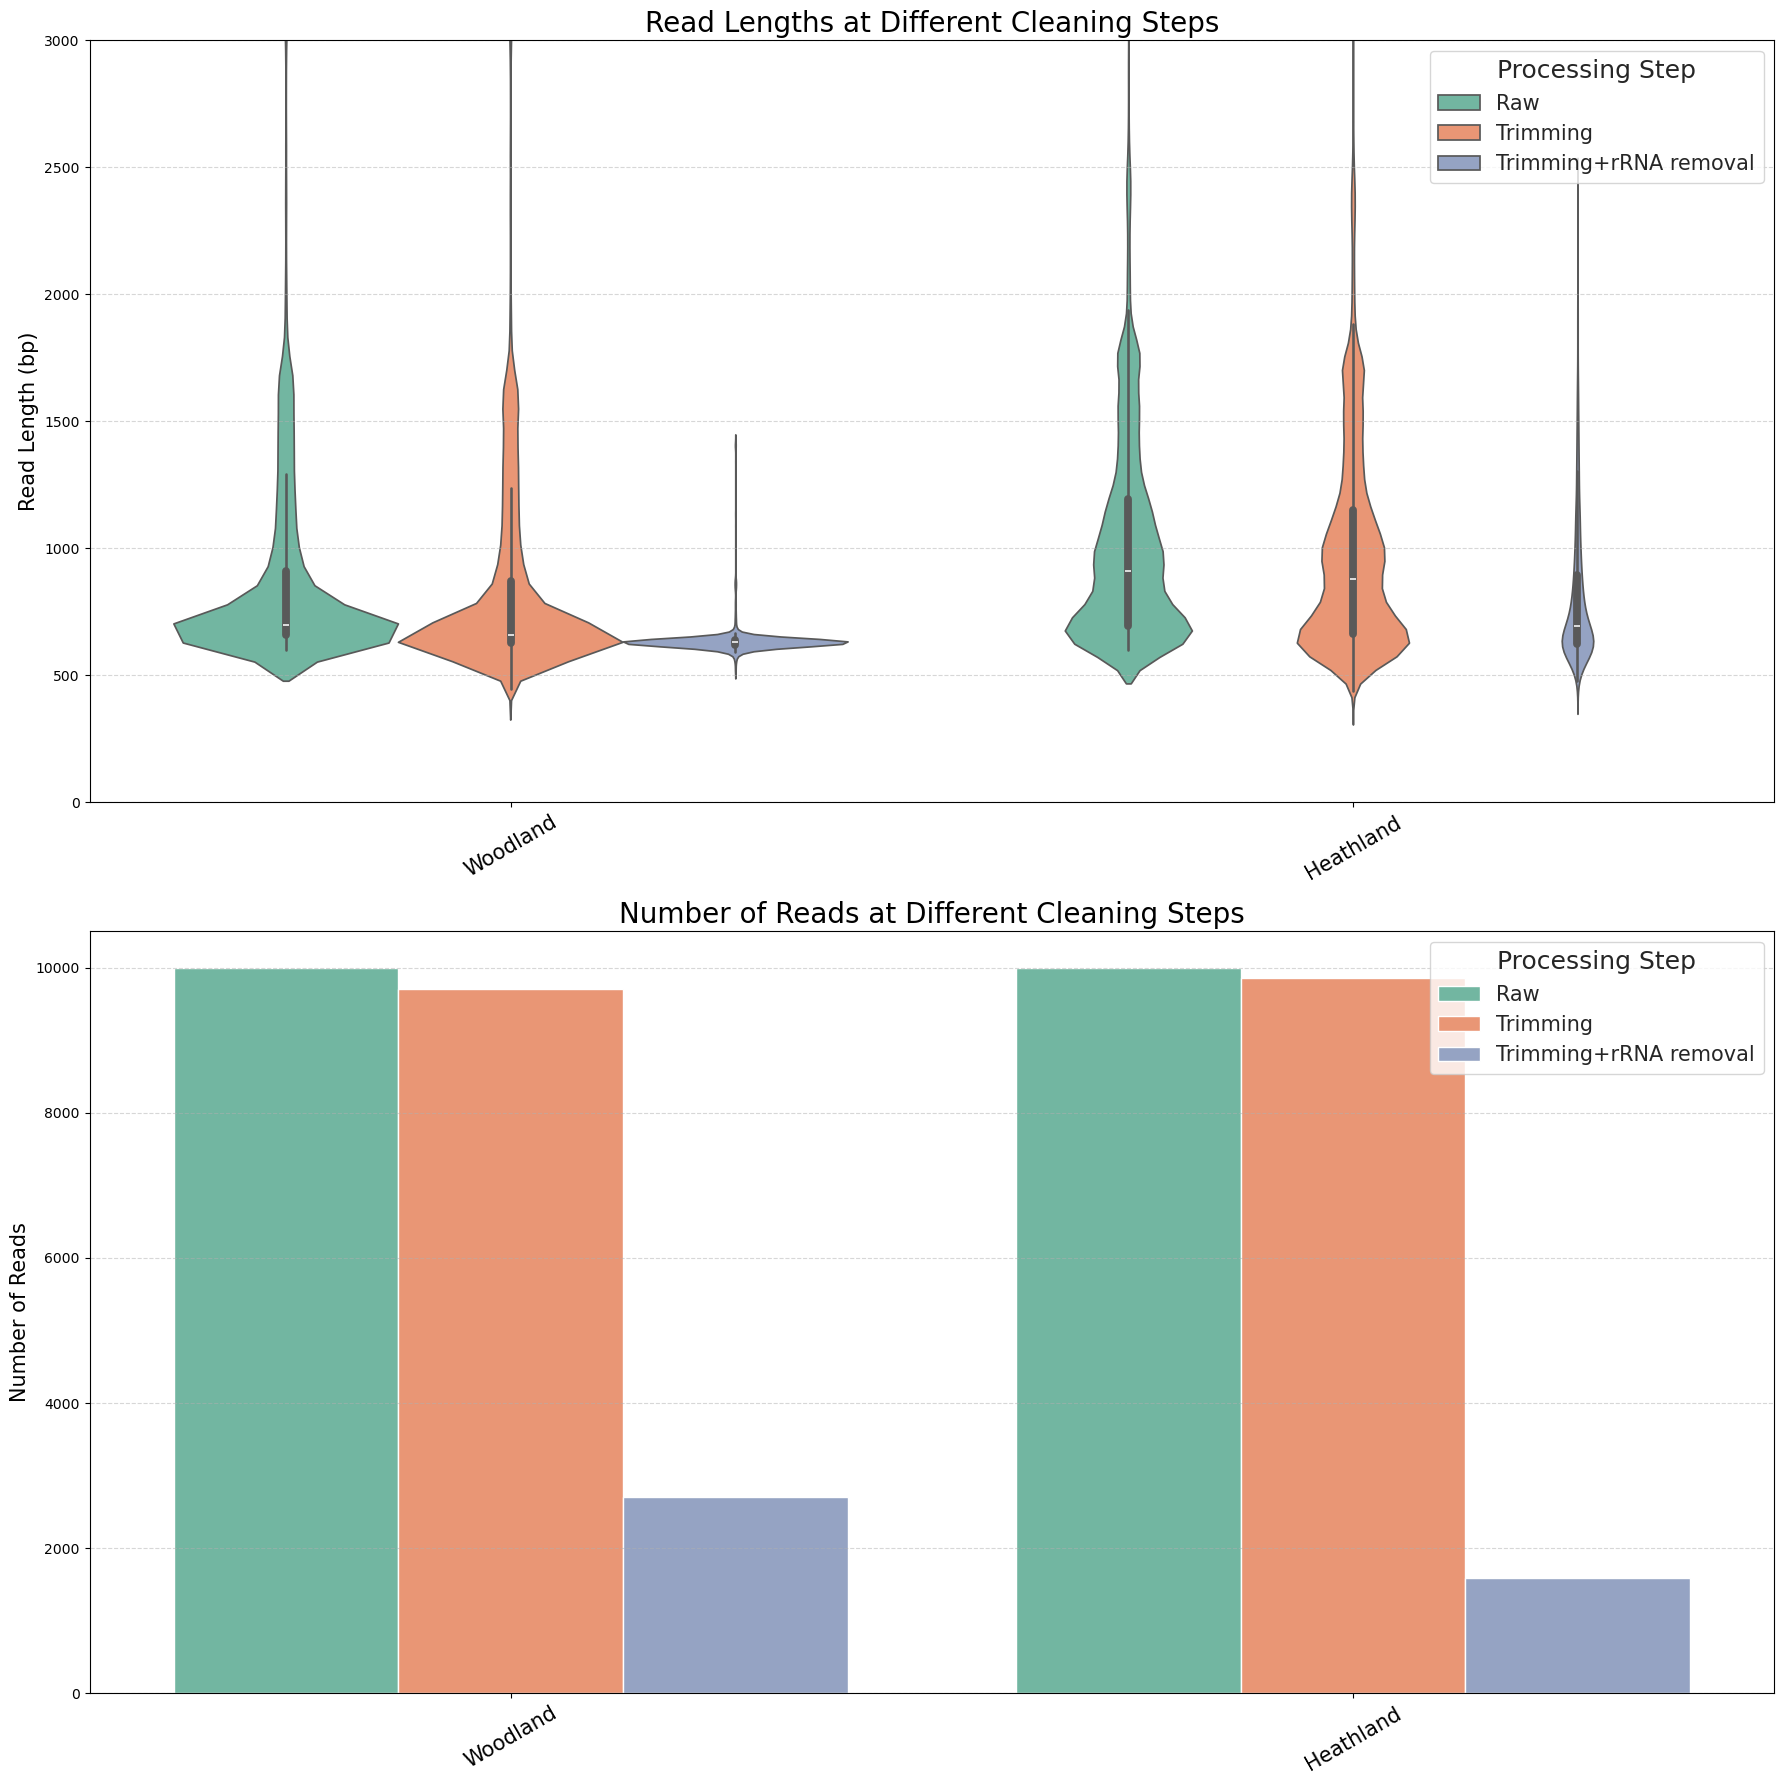

In [32]:
fig, axes = plt.subplots(2,1, figsize=(18, 18))
sns.set(style="whitegrid")

sns.violinplot(
    data=df_violin,
    x="Sample",
    y="Read Length (bp)",
    hue="Processing-step",
    hue_order=["Raw", "Trimming", "Trimming+rRNA removal"],
    palette="Set2",
    inner="box",
    density_norm="area",
    ax=axes[0]
)
axes[0].set_title("Read Lengths at Different Cleaning Steps", fontsize=20)
axes[0].set_ylabel("Read Length (bp)", fontsize=15)
axes[0].set_xlabel("")
axes[0].legend(title="Processing Step", loc='upper right', fontsize=15, title_fontsize=18)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].set_ylim(0, 3000)
axes[0].tick_params(axis='x', rotation=30, labelsize=15)

sns.barplot(
    data=df_bar,
    x="Sample",
    y="Reads",
    hue="Processing-step",
    hue_order=["Raw", "Trimming", "Trimming+rRNA removal"],
    estimator=sum,
    dodge=True,
    palette="Set2",
    ax=axes[1]
)
axes[1].set_title("Number of Reads at Different Cleaning Steps", fontsize=20)
axes[1].set_ylabel("Number of Reads", fontsize=15)
axes[1].set_xlabel("")
axes[1].legend(title="Processing Step", loc='upper right', fontsize=15, title_fontsize=18)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].tick_params(axis='x', rotation=30, labelsize=15)

plt.tight_layout()
plt.show()


- Could the initial sample readset quality have affected the results? 
- Are differences between raw and trimming substantial? And between raw and trimming+rRNA removal?